# Linear Regression with 5 fold CV

In [3]:
# import the necessary libraries 

import import_ipynb
from iv_test_train_split import *
from v_utils import *

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: ignored

In [ ]:
# Fit a linear regression model to the training data
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

# Get summary statistics
summary = model.summary()
print(summary)

# Calculate the point prediction for the testing data
X_test = sm.add_constant(X_test)
point_pred = model.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     100.5
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        06:12:36   Log-Likelihood:                -1791.6
No. Observations:                4456   AIC:                             3679.
Df Residuals:                    4408   BIC:                             3986.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9631      0.007    671.141      0.0

In [ ]:
# Calculate the 50% prediction interval lower/upper bounds for the testing data
alpha = 0.5
se = np.sqrt(model.mse_resid)
t_val_50 = np.abs(stats.t.ppf(alpha/2, model.df_resid))
interval_width_50 = t_val_50 * se
lower_bound_50 = point_pred - interval_width_50
upper_bound_50 = point_pred + interval_width_50

#Calculate the interval score for the testing data
interval_score_50 = interval_score_linear(point_pred, y_test, lower_bound_50, upper_bound_50, alpha)
interval_score_50 = np.exp(interval_score_50)

# Calculate the coverage rate for the testing data
coverage_rate_50 = np.mean((lower_bound_50 <= y_test) & (y_test <= upper_bound_50))

# Calculate the average length of the prediction intervals for the testing data
avg_length_50 = np.mean(upper_bound_50 - lower_bound_50)

predictions50 = pd.concat([
    np.exp(y_test).reset_index(drop=True),
    pd.Series(np.exp(point_pred), name='point_estimate'),
    pd.Series(np.exp(lower_bound_50), name='lower_bound'),
    pd.Series(np.exp(upper_bound_50), name='upper_bound')
], axis=1).round(3)

# Print the results for 50% prediction interval
print(predictions50)
print("Interval Score:", interval_score_50.round(3))
print("Coverage rate:", coverage_rate_50.round(3))
print("Average length:", avg_length_50.round(3))

      price  point_estimate  lower_bound  upper_bound
0      80.0          69.370       54.278       88.657
1     195.0          74.933       58.632       95.768
2     100.0         135.422      105.961      173.074
3      40.0          60.093       47.020       76.801
4     260.0         146.462      114.599      187.184
...     ...             ...          ...          ...
1110  180.0          85.139       66.617      108.811
1111   59.0          54.237       42.438       69.316
1112   99.0          84.745       66.309      108.307
1113   49.0          50.456       39.479       64.484
1114  200.0         144.579      113.126      184.777

[1115 rows x 4 columns]
Interval Score: 4.022
Coverage rate: 0.52
Average length: 0.491


In [ ]:
# Calculate the 80% prediction interval lower/upper bounds for the testing data
alpha = 0.2
se = np.sqrt(model.mse_resid)
t_val_80 = np.abs(stats.t.ppf(alpha/2, model.df_resid))
interval_width_80 = t_val_80 * se
lower_bound_80 = point_pred - interval_width_80
upper_bound_80 = point_pred + interval_width_80
pred_obj = np.column_stack((point_pred, lower_bound_80, upper_bound_80))

#Calculate the interval score for the testing data
interval_score_80 = interval_score_linear(point_pred, y_test, lower_bound_80, upper_bound_80, alpha)
interval_score_80 = np.exp(interval_score_80)

# Calculate the coverage rate for the testing data
coverage_rate_80 = np.mean((lower_bound_80 <= y_test) & (y_test <= upper_bound_80))

# Calculate the average length of the prediction intervals for the testing data
avg_length_80 = np.mean(upper_bound_80 - lower_bound_80)

# Print the results for 80% prediction interval
predictions80 = pd.concat([
    np.exp(y_test).reset_index(drop=True),
    pd.Series(np.exp(point_pred), name='point_estimate'),
    pd.Series(np.exp(lower_bound_80), name='lower_bound'),
    pd.Series(np.exp(upper_bound_80), name='upper_bound')
], axis=1).round(3)

print(predictions80)
print("Interval Score:", interval_score_80.round(3))
print("Coverage rate:", coverage_rate_80.round(3))
print("Average length:", avg_length_80.round(3))

      price  point_estimate  lower_bound  upper_bound
0      80.0          69.370       43.523      110.565
1     195.0          74.933       47.014      119.433
2     100.0         135.422       84.965      215.843
3      40.0          60.093       37.703       95.780
4     260.0         146.462       91.892      233.439
...     ...             ...          ...          ...
1110  180.0          85.139       53.417      135.699
1111   59.0          54.237       34.029       86.445
1112   99.0          84.745       53.170      135.071
1113   49.0          50.456       31.656       80.419
1114  200.0         144.579       90.710      230.438

[1115 rows x 4 columns]
Interval Score: 8.87
Coverage rate: 0.812
Average length: 0.932


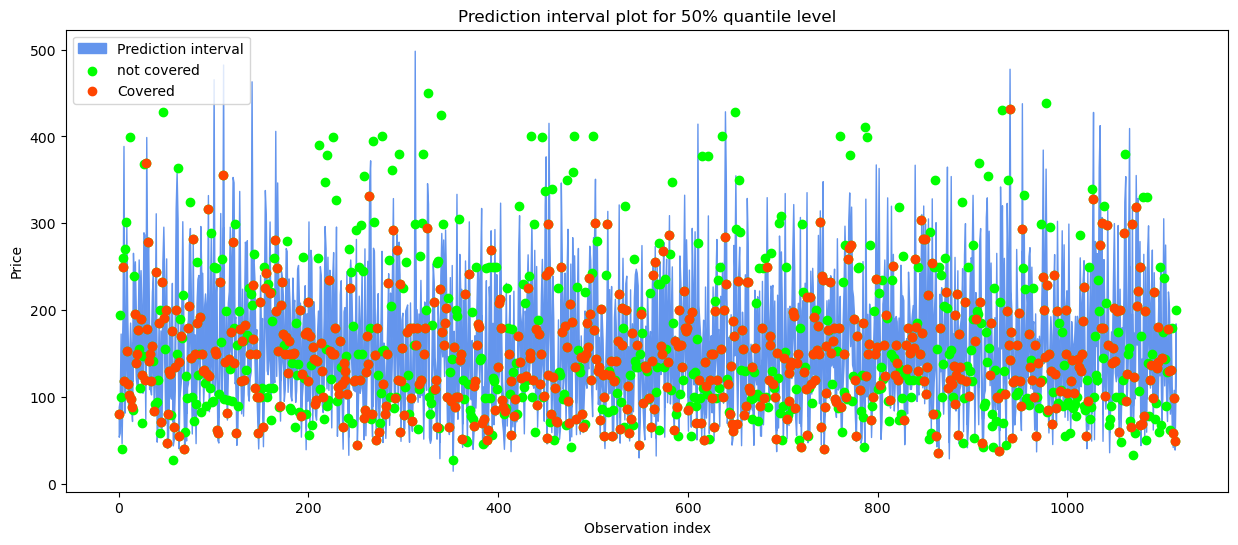

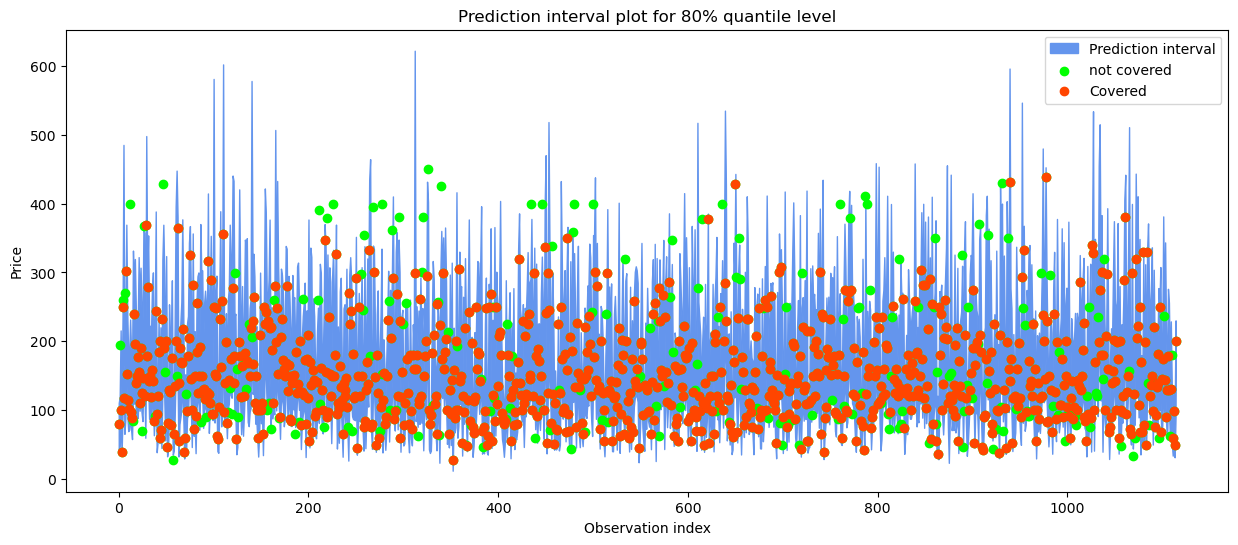

In [ ]:
plot_prediction_interval(y_test, lower_bound_50, upper_bound_50, 50)
plot_prediction_interval(y_test, lower_bound_80, upper_bound_80, 80)

In [ ]:
"""
    @input:
    - X (pandas DataFrame): Data with features.
    - y (pandas Series): Data with target variable.
    - k (int): Number of folds for cross-validation.
    - alpha_levels (list): Quantile levels for loss function.
    
    @output: DataFrame containing metrics for each fold and their average values.
    
    @purpose: Cross-validate a Gradient Boosting Regressor model on the given data and calculate various metrics.
    
"""


def cross_validate_metrics(X, y, k=5, alpha_levels=[0.5, 0.8]):
    kf = KFold(n_splits=k, shuffle=True, random_state=447)
    
    metrics_results = []
    fold_num = 1
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train models and make predictions
        model = sm.OLS(y_train, X_train).fit()
        point_estimate = model.predict(X_test)
        
        #Calculate prediction intervals
        lower_bounds = {}
        upper_bounds = {}
        
        for alpha in alpha_levels:
            se = np.sqrt(model.mse_resid)
            t_val = np.abs(stats.t.ppf((1 - alpha)/2, model.df_resid))
            interval_width = t_val * se
            lower_bound = point_estimate - interval_width
            upper_bound = point_estimate + interval_width
            
            lower_bounds[alpha] = lower_bound
            upper_bounds[alpha] = upper_bound
        
        # Calculate metrics
        aic = AIC_linear(model, X_train, y_train)
        mse = metrics.mean_squared_error(y_test, point_estimate)
        rmse = np.sqrt(mse)
        
        interval_metrics = {}
        for alpha in alpha_levels:
            pred_obj = np.column_stack((point_estimate, lower_bounds[alpha], upper_bounds[alpha]))
            interval_result = interval_score(pred_obj, y_test.values, alpha)
            
            interval_metrics[alpha] = {
                f'Interval Average Length ({alpha})': interval_result['summary'][1],
                f'Interval Score ({alpha})': interval_result['summary'][2],
                f'Coverage Rate ({alpha})': interval_result['summary'][3]
            }
        
        metrics_results.append({
            'Fold': fold_num,
            'AIC': aic,
            'MSE': mse,
            'RMSE': rmse,
            **{f"{key}": value for alpha, metrics_dict in interval_metrics.items() for key, value in metrics_dict.items()}
        })
        
        fold_num += 1
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame(metrics_results)
    
    # Calculate average values and append them to the DataFrame
    avg_metrics = {
        'Fold': 'Average',
        'AIC': results_df['AIC'].mean(),
        'MSE': results_df['MSE'].mean(),
        'RMSE': results_df['RMSE'].mean(),
        **{key: results_df[key].mean() for key in results_df.columns if 'Interval' in key or 'Coverage' in key}
    }
    
    results_df = results_df.append(avg_metrics, ignore_index=True)
    
    # Round the values to 3 decimals
    results_df = results_df.round(3)
    
    # Set the DataFrame index to the 'Fold' column
    results_df.set_index('Fold', inplace=True)
    
    return results_df

In [ ]:
results_linear = cross_validate_metrics(X, y_log)

In [ ]:
display(results_linear)

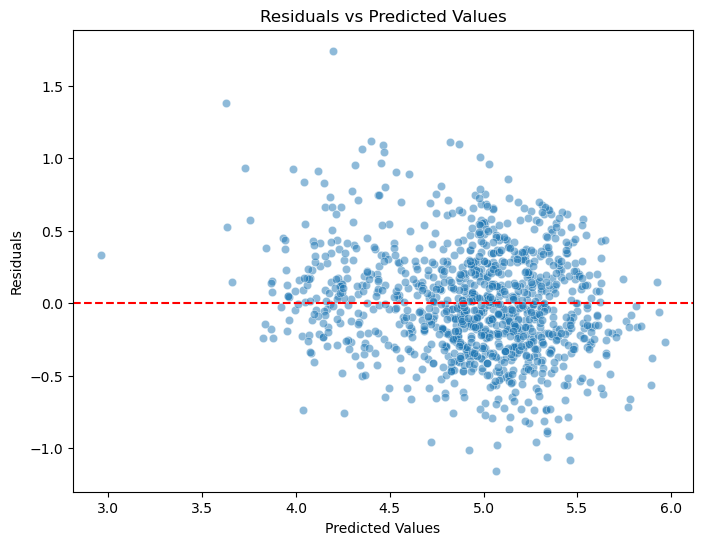

In [ ]:
# Residual plot
plt.figure(figsize=(8, 6))
residuals = y_test - point_pred
sns.scatterplot(x= point_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()